In [1]:
from local_optim_fit import reorder_df, forge_axcaliber_250k, fit_dict_axcaliber, local_optim_test_indata
from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.core.acquisition_scheme import acquisition_scheme_from_qvalues
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from dmipy.distributions import distribute_models
from scipy.optimize import curve_fit, minimize
import pandas as pd
from scipy.stats import gamma
from dmipy.core.acquisition_scheme import acquisition_scheme_from_gradient_strengths
from scipy.interpolate import CubicSpline, interp1d
from matplotlib.ticker import LinearLocator
import nibabel as nib
import copy
import pickle

### Fit the raw data

In [ ]:
cost_mat = []
param_mat = []
forward_model = forge_axcaliber()
for perm in np.arange(0, 0.021, 0.001):
    costs = []
    params = []
    for i in np.arange(0.30, 5.51, 0.10):
        # a = '{0:.2f}'.format(i)
        simdata = pd.read_csv("./perm/signal_MT_0_sus_0_perm_" + '{0:.3f}'.format(perm) + "_rmean_" + '{0:.2f}'.format(i) + "_density_0.65.csv", header=None)

        y = simdata[2].to_numpy()/simdata[2][0]
        cost, param = local_optim_test_indata(forward_model, y)
        costs.append(cost)
        params.append(param)
    cost_mat.append(costs)
    param_mat.append(params)

To skip fitting parameters from raw data, use the pre-fitted parameters

In [2]:
file_path = "params_samepack_scaled_perm_0-0.02_250k_rep100r.pickle"
with open(file_path, 'rb') as file:
    params = pickle.load( file)

## Figure 4: Parameter estimation and simulated signal with no permeability or MT

Figure 4a

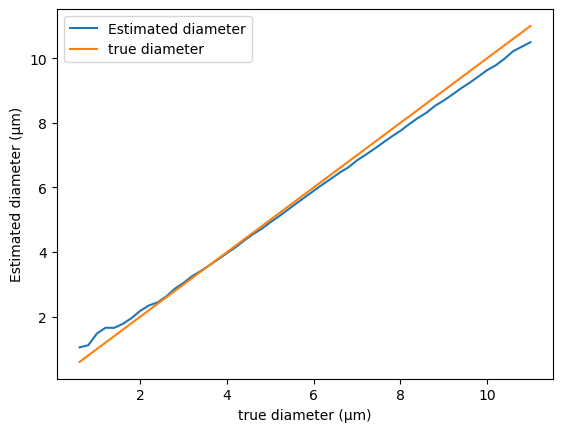

In [3]:
param = params[0]

nm_rfit = []

for a in param:
    nm_rfit.append(a["Nelder-Mead"][2])

plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_rfit)*2, label="Estimated diameter")
plt.plot(np.arange(0.30, 5.51, 0.10)*2,np.arange(0.30, 5.51, 0.10)*2, label="true diameter")
plt.xlabel("true diameter (μm)")
plt.ylabel("Estimated diameter (μm)")
plt.legend()

plt.show()

Figure 4b

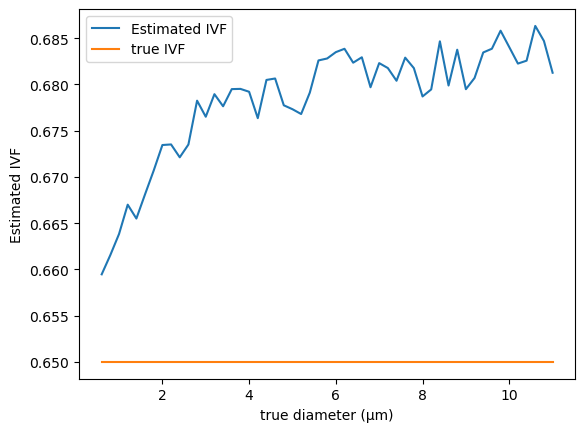

In [4]:

nm_vfit = []

for a in param:
    nm_vfit.append(a["Nelder-Mead"][0])
    
plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_vfit), label="Estimated IVF")
plt.plot([0.6,11],[0.65,0.65], label="true IVF")
plt.xlabel("true diameter (μm)")
plt.ylabel("Estimated IVF")
plt.legend()
# if perm is not None:
#     plt.title("Permeability="+str(perm))
plt.show()

### inspect intracellular and extracellular signals (figure 4c & 4d)

In [14]:
def get_spline():
    Dr = 3e-9
    gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
    gradient_directions = np.tile(np.array([0,1,0]), (128, 1))# np.asarray([[0, 0, 1],[0, 0, 1],[0, 0, 1]])  # Perpendicular to the cylinder
    delta = 0.0025  # s
    Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # s
    acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta)
    ball = gaussian_models.G1Ball()
    ys = [np.ones([128])]
    for i in np.arange(0.30, 5.51, 0.10):
        # a = '{0:.2f}'.format(i)
        simdata = pd.read_csv("./perm/signal_MT_0_sus_0_perm_0.000_rmean_" + '{0:.2f}'.format(i) + "_density_0.65.csv",header=None)

        y = simdata[0].to_numpy()/simdata[0][0]
        ys.append(y)
    np_ys = np.array(ys)
    rs = np.arange(0.30, 5.51, 0.10)
    rs = np.insert(rs, 0, 0)
    ax_intra = CubicSpline(rs, np_ys)

    def spline_with_x(x, r):
        return ax_intra(r)

    return spline_with_x

def fit_cyl_model(y, Dr, r, plot=False, extrapolate=False):
    gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
    gradient_directions = np.tile(np.array([0,1,0]), (128, 1))# np.asarray([[0, 0, 1],[0, 0, 1],[0, 0, 1]])  # Perpendicular to the cylinder
    delta = 0.0025  # s
    Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # s
    cylinder_orient = [0,0]
    initial_params = [r]
    acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta)
    f = get_spline()
    # Perform curve fitting
    if extrapolate:
        popt, pcov = curve_fit(f=f, xdata=0, ydata=y, p0=initial_params, maxfev=5000)
    else:
        popt, pcov = curve_fit(f=f, xdata=0, ydata=y, p0=initial_params, maxfev=5000, bounds=(0.1,10.1))
    
    # Print the optimal parameters
    print('Fitted radius(um):', popt[0])
    
    if plot == True:
        Gamma=42.576e6
        qs = gradient_strengths*Gamma*delta
        fitted_signal = f(0, r=popt[0])
        simulated_signal = y
        plt.scatter(qs[0:16], y[0:16], c='red', label="Simulated, delta=10ms")
        plt.plot(qs[0:16], fitted_signal[0:16], c='red', label="Fitted, delta=10ms")
        plt.scatter(qs[112:128], y[112:128], c='blue', label="Simulated, delta=80ms")
        plt.plot(qs[112:128], fitted_signal[112:128], c='blue', label="Fitted, delta=80ms")
        # plt.plot(qvals, predicted_signal, label="Predicted")
        plt.xlabel("perpendicular q-value [1/m]", fontsize=15)
        plt.ylabel("E(q$_\perp$)", fontsize=15);
        plt.legend()
        plt.show()

    return popt

In [32]:
r_dict = []
for i in np.arange(0.30, 5.51, 0.10):
    # a = '{0:.2f}'.format(i)
    simdata = pd.read_csv("./perm/signal_MT_0_sus_0_perm_0.000_rmean_" + '{0:.2f}'.format(i) + "_density_0.65.csv", header=None)
    r = 0.4
    # corrdata = reorder_df(simdata)
    y = np.array(simdata[0].to_numpy()/simdata[0][0])
    popt = fit_cyl_model(y=y, Dr=3e-9, r=r)
    r_dict.append(popt[0])

Fitted radius(um): 0.30001991011755047
Fitted radius(um): 0.4
Fitted radius(um): 0.500000504505856
Fitted radius(um): 0.600000011606289
Fitted radius(um): 0.7000000010619415
Fitted radius(um): 0.8
Fitted radius(um): 0.9000000000258399
Fitted radius(um): 1.000000000000021
Fitted radius(um): 1.1000000023031038
Fitted radius(um): 1.2000000184815334
Fitted radius(um): 1.3000000000000018
Fitted radius(um): 1.3999999999994317
Fitted radius(um): 1.5000000000000069
Fitted radius(um): 1.5999999999477037
Fitted radius(um): 1.700000000116706
Fitted radius(um): 1.8000000000000034
Fitted radius(um): 1.9000000000042012
Fitted radius(um): 2.000000000464
Fitted radius(um): 2.1000000004262827
Fitted radius(um): 2.200000000000002
Fitted radius(um): 2.3000000000000016
Fitted radius(um): 2.40000000000004
Fitted radius(um): 2.500000000000008
Fitted radius(um): 2.60000000000026
Fitted radius(um): 2.7000000000000064
Fitted radius(um): 2.800000000000019
Fitted radius(um): 2.900000000000001
Fitted radius(um): 

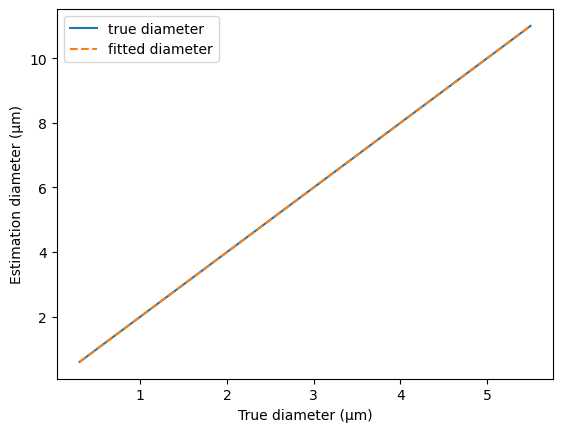

In [60]:
np_r_dict = np.array(r_dict)
rs = np.arange(0.30, 5.51, 0.1)
diff = np_r_dict - rs
diff_ratio = diff/0.2

plt.plot(rs,rs*2,label="true diameter")
plt.plot(rs, np_r_dict*2, label="fitted diameter", linestyle='--')
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimation diameter (μm)")
plt.legend()
plt.show()


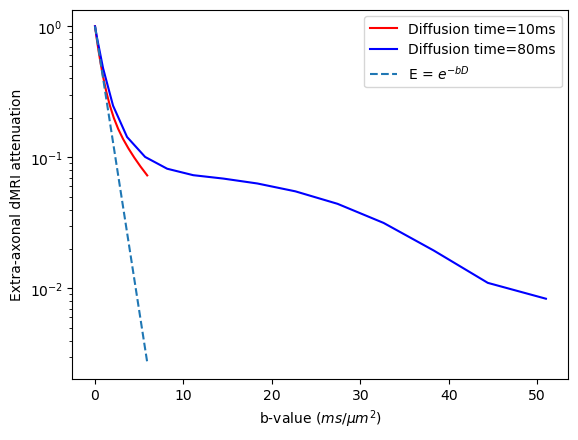

In [61]:
simdata = pd.read_csv("perm/signal_MT_0_sus_0_perm_0.000_rmean_5.50_density_0.65.csv", header=None)
r = 2
Dr = 3e-9
corrdata = reorder_df(simdata)
y = simdata[1].to_numpy()/simdata[1][0]
gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
gradient_directions = np.tile(np.array([0,1,0]), (128, 1))# np.asarray([[0, 0, 1],[0, 0, 1],[0, 0, 1]])  # Perpendicular to the cylinder
delta = 0.0025  # s
Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # s
acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta)
plt.semilogy(acq_scheme.bvalues[0:16]*1e-9, (y[0:16]), c='red', label="Diffusion time=10ms")
# plt.plot(qs[0:16], fitted_signal[0:16], c='red', label="Fitted, delta=10ms")
plt.semilogy(acq_scheme.bvalues[112:128]*1e-9, (y[112:128]), c='blue', label="Diffusion time=80ms")
plt.semilogy(acq_scheme.bvalues[0:16]*1e-9, np.exp(-acq_scheme.bvalues[0:16]*1e-9), label="E = ${e^{-bD}}$", linestyle='--')
# plt.plot(qs[112:128], fitted_signal[112:128], c='blue', label="Fitted, delta=80ms")
# plt.plot(qvals, predicted_signal, label="Predicted")
plt.xlabel("b-value ($ms/μm^2$)")
plt.ylabel("Extra-axonal dMRI attenuation");
plt.legend()
plt.show()

## Figure 5: Diameter (5a) and IVF (5b) estimation with semi-permeable cylinders, uniform diameter

Figure 5a

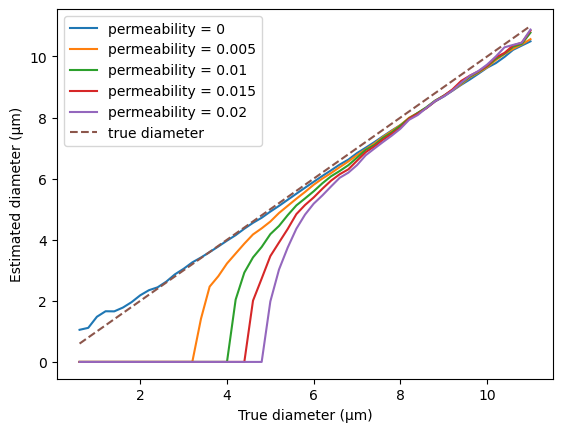

In [6]:
perm_list = [0, 0.005, 0.01, 0.015, 0.02]
for index in range(5):
    # costs = cost_mat[index*5]
    param = params[index*5]
    nm_rfit = []

    for a in param:

        nm_rfit.append(a["Nelder-Mead"][2])

    plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_rfit)*2, label="permeability = " + str(perm_list[index]))

plt.plot(np.arange(0.30, 5.51, 0.10)*2,np.arange(0.30, 5.51, 0.10)*2, label="true diameter", linestyle='--')
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimated diameter (μm)")
plt.legend()

plt.show()

Figure 5b

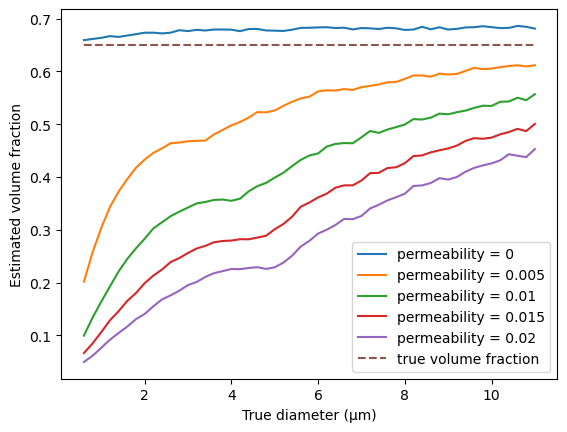

In [9]:
for index in range(5):
    param = params[index*5]

    nm_vfit = []

    for a in param:

        nm_vfit.append(a["Nelder-Mead"][0])
    
    
    plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_vfit), label="permeability = " + str(perm_list[index]))
plt.plot([0.6,11],[0.65,0.65], label="true volume fraction", linestyle='--')
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimated volume fraction")
plt.legend()
plt.show()

## Figure 9: Simulated diffusion signal attenuation with and without permeability

Figure 9a

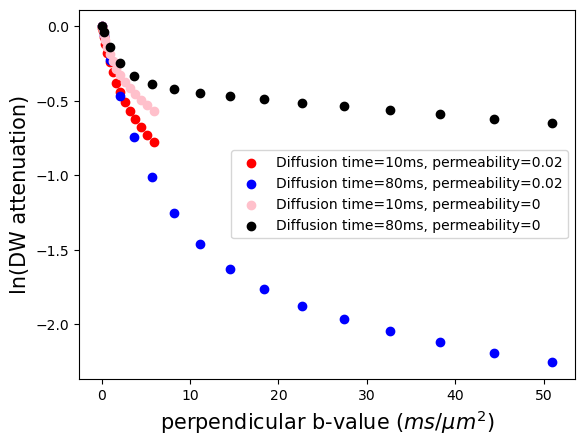

In [74]:
simdata = pd.read_csv("perm/signal_MT_0_sus_0_perm_0.020_rmean_2.00_density_0.65.csv", header=None)
y = simdata[2].to_numpy()/simdata[2][0]
yex = simdata[1].to_numpy()/simdata[2][0]/0.35
# cost, param = local_optim_test_indata(forward_model, y)
gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
gradient_directions = np.tile(np.array([0,1,0]), (128, 1))# np.asarray([[0, 0, 1],[0, 0, 1],[0, 0, 1]])  # Perpendicular to the cylinder
Gamma=42.576e6
delta = 0.0025
qs = gradient_strengths*Gamma*delta
Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # s
acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta)
# fitted_signal = forward_model(nm_fit[0][0], nm_fit[0][1]*1e-9, nm_fit[0][2])
plt.scatter(acq_scheme.bvalues[0:16]*1e-9, np.log(y[0:16]), c='red', label="Diffusion time=10ms, permeability=0.02")
# plt.plot(qs[0:16], fitted_signal[0:16], c='red', label="Fitted, delta=10ms")
plt.scatter(acq_scheme.bvalues[112:128]*1e-9, np.log(y[112:128]), c='blue', label="Diffusion time=80ms, permeability=0.02")

simdata00 = pd.read_csv("perm/signal_MT_0_sus_0_perm_0.000_rmean_2.00_density_0.65.csv", header=None)
y00 = simdata00[2].to_numpy()/simdata00[2][0]
yex00 = simdata00[1].to_numpy()/simdata00[2][0]
# cost50, param50 = local_optim_test_indata(forward_model, y50)
# fitted_signal50 = forward_model(nm_fit50[0][0], nm_fit50[0][1]*1e-9, nm_fit50[0][2])
plt.scatter(acq_scheme.bvalues[0:16]*1e-9, np.log(y00[0:16]), c='pink', label="Diffusion time=10ms, permeability=0")
# plt.plot(qs[0:16], fitted_signal50[0:16], c='yellow', label="Fitted, delta=10ms, MT=50ms")
plt.scatter(acq_scheme.bvalues[112:128]*1e-9, np.log(y00[112:128]), c='black', label="Diffusion time=80ms, permeability=0")
# plt.plot(qs[112:128], fitted_signal50[112:128], c='green', label="Fitted, delta=80ms, MT=50ms")

plt.xlabel("perpendicular b-value ($ms/μm^2$)", fontsize=15)
plt.ylabel("ln(DW attenuation)", fontsize=15);
# plt.title("perm=0.02")
plt.legend()
plt.show()

Figure 9b

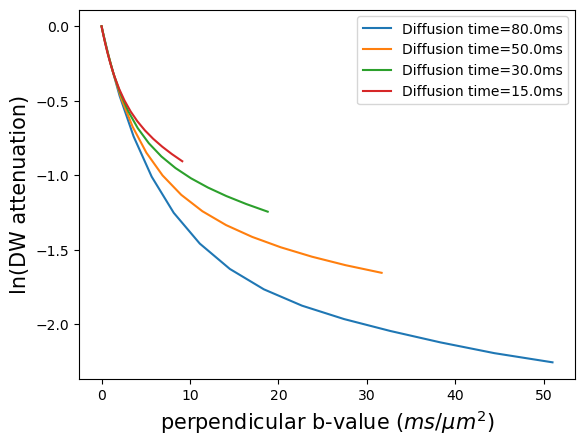

In [77]:
simdata = pd.read_csv("perm/signal_MT_0_sus_0_perm_0.020_rmean_2.00_density_0.65.csv", header=None)
y = simdata[2].to_numpy()/simdata[2][0]
yex = simdata[1].to_numpy()/simdata[2][0]/0.35
# cost, param = local_optim_test_indata(forward_model, y)
gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
gradient_directions = np.tile(np.array([0,1,0]), (128, 1))# np.asarray([[0, 0, 1],[0, 0, 1],[0, 0, 1]])  # Perpendicular to the cylinder
Gamma=42.576e6
delta = 0.0025
qs = gradient_strengths*Gamma*delta
Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # s
acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta)
for i in range(7,-1,-2):
    plt.plot(acq_scheme.bvalues[16*i:16*(i+1)]*1e-9, np.log(y[16*i:16*(i+1)]), label="Diffusion time="+str([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08][i]*1000)+"ms")


plt.xlabel("perpendicular b-value ($ms/μm^2$)", fontsize=15)
plt.ylabel("ln(DW attenuation)", fontsize=15);
# plt.title("perm=0.02")
plt.legend()
plt.show()